# Line-of-sight shear in SLACS strong lenses I
_Natalie B. Hogg, Daniel Johnson, Anowar J. Shajib, and Julien Larena (2025)_
arXiv: 2501.16292v2

This notebook allows you to reproduce the figures shown in the above paper. It assumes you are working in a Python environment with the packages listed in the following cells installed, and that you have downloaded the necessary data files from the following Zenodo repository: https://zenodo.org/records/17816315. You then just need to provide the path to where you downloaded the data:

In [1]:
path = r'/home/nataliehogg/Documents/Projects/slacs/zenodo/'

### Import packages

In [2]:
# reading files
import sys
import pickle
import yaml
import pandas as pd

In [3]:
# computations
import numpy as np

In [4]:
# plots, colours and style
from matplotlib import rc, offsetbox, colors, cm, patches, pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

import cmasher as cmr
import cmocean as cmo

# apply sanglier style
plt.rcParams.update({
  'lines.linewidth': 3.0,
  'font.family': 'serif',
  'font.size': 14,
  'text.usetex': True,
  'axes.prop_cycle': cycler('color', ['#a0c3db', '#dbb7a0', '#c2a5cf', '#a6dba0'])
})

# neat colourbar handler
def colorbar(mappable, lab, padding, fontsize, **kwargs):
    # thanks to Joseph Long! https://joseph-long.com/writing/colorbars/
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '2.5%', pad = padding)
    cbar = fig.colorbar(mappable, cax = cax, **kwargs)
    cbar.set_label(lab, size=fontsize)
    cbar.ax.tick_params(labelsize=fontsize) 
    plt.sca(last_axes)
    return cbar

# get provided implementation of cubehelix colourmap so that we can manipulate the colours
sys.path.insert(0, path)
import cubehelix
cmap_cubehelix = cubehelix.cmap(reverse=False, start=0.5, rot=-0.5, gamma=1.0, sat=1.0) # hue in original cubehelix docs is called sat here

In [5]:
# stop Juypter complaining about a divide by zero in lenstronomy
import warnings
warnings.filterwarnings('ignore')

### Read in data

In [6]:
# external shear measurements collected from Shajib et al. (2021), Tan et al. (2024), Etherington et al. (2024)
literature_df = pd.read_csv(path+'anowar_chinyi_amy_shears.csv')

In [7]:
# minimal model results
min_df = pd.read_csv(path+'MIN_shear_and_redshifts_paper_I.csv')

# minimal with gamma_od = 0 results
godf_df = pd.read_csv(path+'GODF_shear_and_redshifts_paper_I.csv')

In [8]:
# shears from N-body simulations
sampled_los_effects = []
for i, name in enumerate(min_df['Name']):
    filename = path+f'RayGalGroupSims_for_slacs/{name}'
    with open(filename, 'rb') as f:
        sampled_los_effects.append(pickle.load(f))        

### Figure 1 
Histogram of shears compared to Shajib et al. (2021)

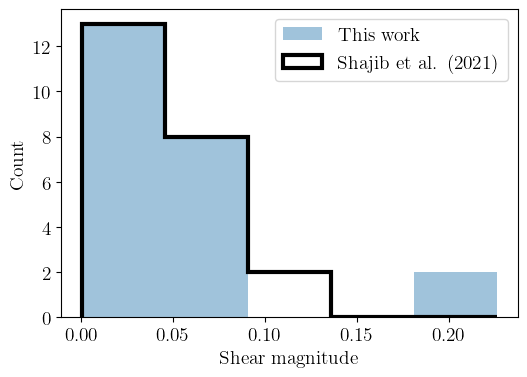

In [9]:
counts, bins = np.histogram(min_df['gamma_los'], bins=5)

fig, ax = plt.subplots(1,1, figsize=(5.5,4))

ax.hist(min_df['gamma_los'], bins=bins, density=False,label='This work')
ax.hist(literature_df['Anowar'].dropna(), bins=bins, histtype='step', 
        lw=3, color='k', density=False, label='Shajib et al. (2021)')

ax.set_xlabel('Shear magnitude')
ax.set_ylabel('Count')

plt.legend(ncol=1)

plt.tight_layout()

plt.show()

### Figures 2, 3, 4 and 5

⚠️ These figures rely on the following versions of `dolphin` and `ChainConsumer`:
- [dolphin](https://github.com/nataliehogg/dolphin); branch `master`, commit `73e244e` for absolute reproducibility.
- [ChainConsumer](https://github.com/Samreay/ChainConsumer); branch `master`, commit `234d840` for absolute reproducibility.

To run the cell below, clone the above-linked repositories, navigate to the relevant directories and run `$ pip install -e .` 

Another word of caution: all figures showing posteriors in the paper were generated in the following way: 
1) chain extracted from the `dolphin` output object and saved in `.h5` file
2) `.h5` file loaded into plotting script as a DataFrame and burn-in removed
3) figures produced

To avoid uploading both the chains and output files to Zenodo, in this notebook we show how to plot by directly extracting the chain from the dolphin output object. In practice (and for an untraceable reason), this introduces some very small numerical discrepancies in the best-fit values quoted for some parameters.

In [10]:
# import dolphin
from dolphin.analysis.output import Output

# import chainconsumer
from chainconsumer import Chain, ChainConsumer, PlotConfig
from chainconsumer.plotting import plot_dist
c = ChainConsumer()

In [11]:
def lims_getter_1d(chain, px, nsig=5):
    '''
    gets x limits for the 1D distribution plot based on the parameter summary
    '''
    from chainconsumer.analysis import Analysis

    analysis = Analysis(None)
    param_summary = analysis.get_parameter_summary(chain, px)

    if param_summary is not None and param_summary.lower is not None and param_summary.upper is not None:
        # Use the parameter summary to get the range
        lower = param_summary.lower
        upper = param_summary.upper
        center = param_summary.center

        # Extend by nsig times the standard deviation
        std = max(center - lower, upper - center)
        x_lower = center - nsig * std
        x_upper = center + nsig * std

        return x_lower, x_upper
    else:
        # Fallback: use data percentiles
        data = chain.get_data(px)
        lower_percentile = np.percentile(data, 0.1)
        upper_percentile = np.percentile(data, 99.9)
        return lower_percentile, upper_percentile

Here we set the model ID. There are four options: 
- `full`, the baseline EPL + minimal LOS model
- `godf`, or "gamma_od fixed", the baseline EPL + minimal LOS model with $\gamma_{\rm od}=0$
- `wlos`, the baseline EPL + minimal LOs model with $\gamma_{\rm od} = \omega_{\rm LOS} = 0$
- `bodi`, the baseline _boxy/disky_ EPL + minimal LOS model. 

Figures 2-5 in the paper show the `full` model results.

In [12]:
model_id = 'full'

In [13]:
params = [r'$\gamma_{\rm lens}$', r'$e_{1, \rm lens}$', r'$e_{2, \rm lens}$', r'$x_{\rm lens}$', r'$y_{\rm lens}$',
          r'$\gamma^{\rm od}_1$', r'$\gamma^{\rm od}_2$', r'$\gamma^{\rm LOS}_1$', r'$\gamma^{\rm LOS}_2$', r'$\omega^{\rm LOS}$', 
          r'$\beta$', r'$x_{\rm s}$', '$y_{\rm s}$', r'$R_{\rm Sersic, s}$', r'$n_{\rm Sersic, s}$', r'$e_1^{\rm s}$', r'$e_2^{\rm s}$',
          r'$R_{\rm Sersic, ll1}$', r'$e_1^{\rm ll1}$', r'$e_2^{\rm ll1}$', r'$x_{\rm ll}$', r'$y_{\rm ll}$', 
          r'$R_{\rm Sersic, l2}$',r'$e_1^{\rm ll2}$',r'$e_2^{\rm ll2}$',]

SDSSJ0029-0055
-0.7957884250080437 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.795788425008045


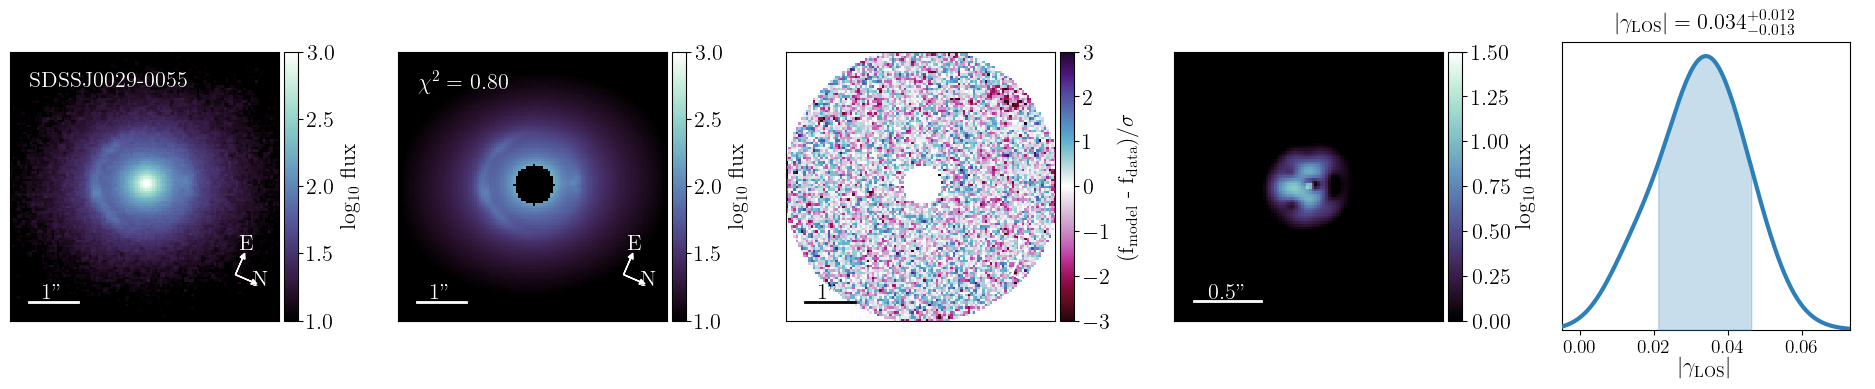

In [14]:
lens_df = pd.read_csv(path+'lens_database.csv')

output = Output(path+'lens_modelling_results/')

paperI_indices = [1,2,4,5,6,7,9,13,19,24,27,28,29,31,34,37,38,39,40,42,43,45,48]

# paperII_indices = [0,3,8,10,11,12,14,15,16,17,18,20,21,23,25,26,30,33,35,36,41,44,46,47,49]

lens_index = 1

try:
    # get meta-data related to name, colourbars, burnin etc
    lens_name = lens_df.iloc[lens_index]['Name']
    print(lens_name)
    lens_filter = lens_df.iloc[lens_index]['Filter']
    v_min = lens_df.iloc[lens_index]['vmin']
    v_max = lens_df.iloc[lens_index]['vmax']
    source_vmin = lens_df.iloc[lens_index]['source_vmin']
    source_vmax = lens_df.iloc[lens_index]['source_vmax']
    burnin = int(lens_df.iloc[lens_index]['burnin'])
    nsig = float(lens_df.iloc[lens_index]['nsig'])

    # load the mask
    mask_path = path+'/masks/'+lens_name+'_'+lens_filter+'_mask.txt'

    # load the output
    output.load_output(lens_name=lens_name, model_id=model_id, mask_path=mask_path)

    # get the kwargs_result
    kwargs_result = output.kwargs_result

    # get the lenstronomy ModelPlot
    ModelPlot, vmax, chi2 = output.get_model_plot(lens_name=lens_name, model_id=model_id,
                                                  mask_path=mask_path, kwargs_result=kwargs_result,
                                                  band_index=0, 
                                                  data_cmap = cmap_cubehelix)

    # read in the chain
    chain_dolphin = output.samples_mcmc

    chain_unburned = pd.DataFrame.from_dict({par: val for par, val in zip(params, chain_dolphin.T)})
    
    # remove burnin
    chain = chain_unburned[burnin:]

    # get the g1 and g2 samples
    g1_los_samples = chain[r'$\gamma^{\rm LOS}_1$']
    g2_los_samples = chain[r'$\gamma^{\rm LOS}_2$']

    # combine g1 and g2 to get |gamma_LOS| samples
    gamma_los_samples = np.sqrt(g1_los_samples[burnin:]**2. + g2_los_samples[burnin:]**2.)

    # put them in a dataframe for chainconsumer
    glos_df = pd.DataFrame(gamma_los_samples, columns=[r'|\gamma_{\rm LOS}|'])

    # set up plot
    fig = plt.figure(figsize=(20,4))
    
    global_fontsize=16
    
    # use a mosaic for simplicity
    ax_dict = fig.subplot_mosaic([["data", "recon", "resid", "source", "contour"],],)

    # add elements

    # the data
    ModelPlot.data_plot(band_index=0, ax=ax_dict['data'], text='', v_min=v_min, v_max=v_max, font_size=global_fontsize)

    # the model
    ModelPlot.model_plot(band_index=0, ax=ax_dict['recon'], text='', v_min=v_min, v_max=v_max, font_size=global_fontsize)

    # the residuals
    ModelPlot.normalized_residual_plot(band_index=0, ax=ax_dict['resid'], 
                                       cmap=cmr.viola_r,
                                       text='', v_min=-3, v_max=3, font_size=global_fontsize)

    # the source
    ModelPlot.source_plot(band_index=0, ax=ax_dict['source'], deltaPix_source=0.02, numPix=100, text='', 
                          v_min=source_vmin, v_max=source_vmax, scale_size=0.5, font_size=global_fontsize)

    # configure chainconsumer
    c.set_plot_config(PlotConfig(serif=True, usetex=True, summarise=True, label_font_size=global_fontsize, 
                                 tick_font_size=global_fontsize, 
                                 summary_font_size=global_fontsize, max_ticks = 4, spacing=2.0))

    # create the Chain object
    chain_object = Chain(samples=glos_df, name=lens_name, shade=True, 
                                           color='#2c7fb8', 
                                           smooth=20, bins=10,
                                           shade_gradient = 0.4, linewidth=3.0)

    # plot the 1D |gamma_LOS| distribution
    plot_dist(ax_dict['contour'], chain_object, config=c.plotter.config, px=r"|\gamma_{\rm LOS}|", summary=True)

    # get the x-axis limits adapted to this distribution
    xmin, xmax = lims_getter_1d(chain_object, r"|\gamma_{\rm LOS}|", nsig=3)

    # titles, axis labels and axis text
    ax_dict['data'].add_artist(offsetbox.AnchoredText(lens_name, 
                                                      loc='upper left', frameon=False, 
                                                      prop = {'fontsize':global_fontsize, 'color':'white'}))

    ax_dict['recon'].add_artist(offsetbox.AnchoredText(r'$\chi^2 = $ {:.2f}'.format(chi2), 
                                                       loc='upper left', frameon=False, 
                                                       prop = {'fontsize':global_fontsize, 'color':'white'}))

    ax_dict['contour'].set_yticks([])
    ax_dict['contour'].set_xlim(xmin, xmax)
    ax_dict['contour'].set_ylim(bottom=0)
    ax_dict['contour'].set_xlabel(r'$|\gamma_{\rm LOS}|$', fontsize=global_fontsize, labelpad=0)
    ax_dict['contour'].axes.set_box_aspect(1)

    fig.subplots_adjust(left=0.01, right=0.93, top=0.98, bottom=0.12, wspace=0.35) 
    
    plt.show()

except FileNotFoundError:
    pass

### Figure 6

For this figure, we use the LOS shear values computed by ray-tracing through the RayGalGroup simulations (RGGS; [Rasera et al. 2021](www.arxiv.org/abs/2111.08745)). We can compute any statistics of these distributions, and can use either the distribution computed for each observed systems's lens and source redshifts, or average over all lens and source redshifts in our sample. See [Johnson et al. 2025](https://arxiv.org/abs/2501.17153) for more information on this computation.

⚠️ We provide the distributions of $|\gamma_{\rm LOS}|$ which were derived from the publically available RGGS maps; our code to compute these distributions from the maps is included in the repository under `extracting_lines_of_sight.py`.

In [15]:
summary_stats = {}

for i, lens_list in enumerate(sampled_los_effects):
    vals = [d['shear_mag_LOS'] for d in lens_list] #all of the shear magnitudes
    
    # 1, 3 and 5 sigma regions
    mean = np.mean(vals)
    lower_1sigma, upper_1sigma = np.percentile(vals, [16, 84])
    lower_3sigma, upper_3sigma = np.percentile(vals, [0.265, 99.735])
    lower_5sigma, upper_5sigma = np.percentile(vals, [100-99.9999426696856, 99.9999426696856])
    
    # Storing results
    summary_stats[i] = {
        "mean": mean,
        "lower_1sigma": lower_1sigma,
        "upper_1sigma": upper_1sigma,
        'lower_3sigma': lower_3sigma,
        'upper_3sigma': upper_3sigma,
        'lower_5sigma': lower_5sigma,
        'upper_5sigma': upper_5sigma
        }

In [16]:
#a single list holding all sampled shear values
all_shear_mags = [d['shear_mag_LOS'] for lens_list in sampled_los_effects for d in lens_list]

overall_summary_stats = {}

# 1, 3 and 5 sigma regions
mean = np.mean(all_shear_mags)
lower_1sigma, upper_1sigma = np.percentile(all_shear_mags, [16, 84])
lower_3sigma, upper_3sigma = np.percentile(all_shear_mags, [0.265, 99.735])
lower_5sigma, upper_5sigma = np.percentile(all_shear_mags, [100-99.9999426696856, 99.9999426696856])

# Storing results
overall_summary_stats = {
    "mean": mean,
    "lower_1sigma": lower_1sigma,
    "upper_1sigma": upper_1sigma,
    'lower_3sigma': lower_3sigma,
    'upper_3sigma': upper_3sigma,
    'lower_5sigma': lower_5sigma,
    'upper_5sigma': upper_5sigma
}

In [17]:
# compute some fits for plotting

mean_shear = np.array([summary_stats[i]['mean'] for i in range(len(summary_stats))])

lower_1sigma = np.array([summary_stats[i]['lower_1sigma'] for i in range(len(summary_stats))])
upper_1sigma = np.array([summary_stats[i]['upper_1sigma'] for i in range(len(summary_stats))])

lower_3sigma = np.array([summary_stats[i]['lower_3sigma'] for i in range(len(summary_stats))])
upper_3sigma = np.array([summary_stats[i]['upper_3sigma'] for i in range(len(summary_stats))])

lower_5sigma = np.array([summary_stats[i]['lower_5sigma'] for i in range(len(summary_stats))])
upper_5sigma = np.array([summary_stats[i]['upper_5sigma'] for i in range(len(summary_stats))])

fit_mean      = np.polyfit(mean_shear, mean_shear, 1)
fit_lower_1sigma = np.polyfit(mean_shear, lower_1sigma, 1)
fit_upper_1sigma = np.polyfit(mean_shear, upper_1sigma, 1)

fit_lower_3sigma = np.polyfit(mean_shear, lower_3sigma, 1)
fit_upper_3sigma = np.polyfit(mean_shear, upper_3sigma, 1)

fit_lower_5sigma = np.polyfit(mean_shear, lower_5sigma, 1)
fit_upper_5sigma = np.polyfit(mean_shear, upper_5sigma, 1)

# Extend x-range for plotting
x_min = 0.8 * mean_shear.min()
x_max = 1.1 * mean_shear.max()
x_fit = np.linspace(x_min, x_max, 23)

# Evaluate fits
y_lower_fit_1s = np.polyval(fit_lower_1sigma, x_fit)
y_upper_fit_1s = np.polyval(fit_upper_1sigma, x_fit)
y_lower_fit_3s = np.polyval(fit_lower_3sigma, x_fit)
y_upper_fit_3s = np.polyval(fit_upper_3sigma, x_fit)
y_lower_fit_5s = np.polyval(fit_lower_5sigma, x_fit)
y_upper_fit_5s = np.polyval(fit_upper_5sigma, x_fit)

y_mean_fit = np.polyval(fit_mean, x_fit)

#### Compute Tension statistic

Here we compute the tension between the measurement and simulation, defined as
$$
    T_{ab} = \frac{|x_a - x_b|}{\sqrt{\rule{0pt}{2ex}\sigma_a^2 + \sigma_b^2}}.
$$

In [18]:
def Tension(lens_index, measurement, simulation, version='overall'):
    '''
    computes tension between measured gamma_LOS and expectation from simulation
    '''
    if version == 'overall':
        mean = simulation['mean']
        u1 = simulation['upper_1sigma']
    elif version == 'zdzs':
        mean = simulation[lens_index]['mean']
        u1 = simulation[lens_index]['upper_1sigma']
    else:
        return 'Wrong version type!'
    
    numerator = np.linalg.norm(measurement['gamma_los'].values[lens_index] - mean)
    denominator = np.sqrt(measurement['gamma_lower'].values[lens_index]**2. + u1**2.)
    result = numerator/denominator
    return result

In [19]:
zdzs_tensions = [Tension(i, min_df, summary_stats, version='zdzs') for i in range(len(min_df['Name']))]

In [20]:
# figure settings
global_figsize = (14, 7)
cmap_tension = cmo.tools.crop_by_percent(cmo.cm.dense, 20, which='min')

# min and max tension values for the colourbar
max_T = 8
min_T = 0

In [21]:
# boost the fontsize
bump_font = 20

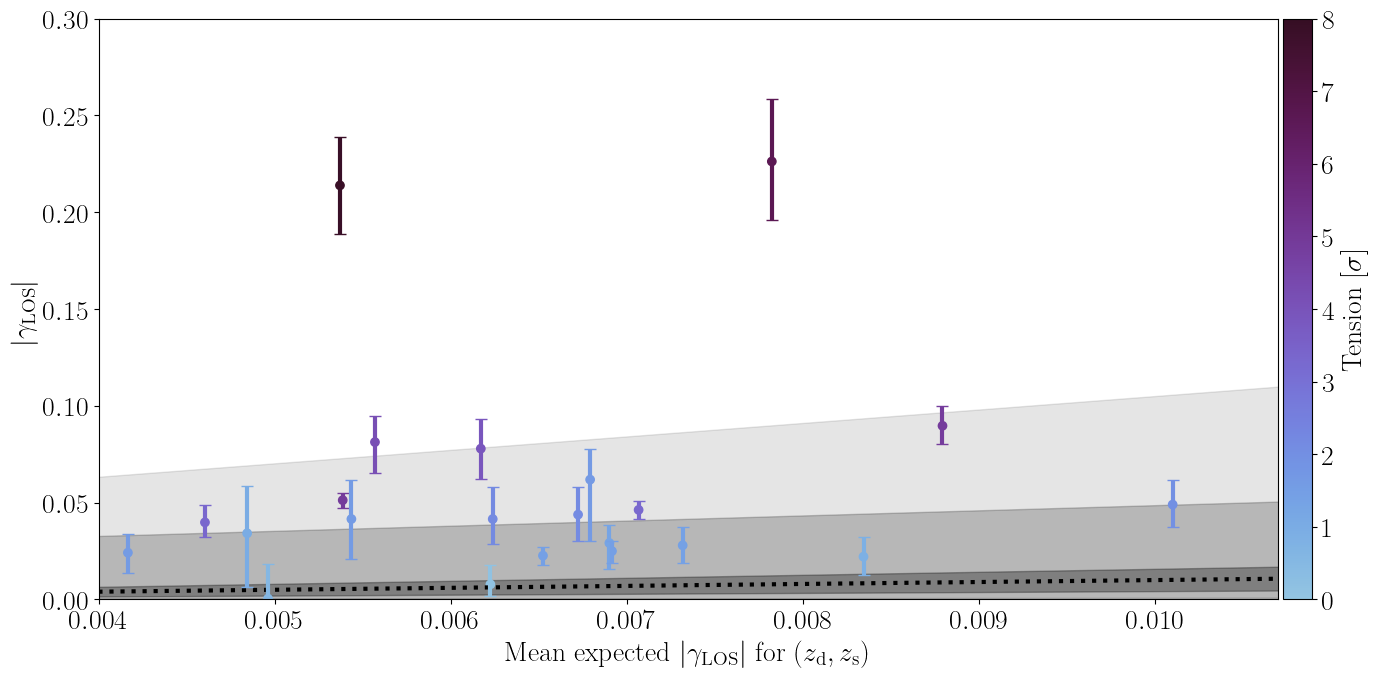

In [22]:
fig, ax = plt.subplots(1, 1, figsize=global_figsize)

ax.fill_between(x_fit, y_lower_fit_1s, y_upper_fit_1s, color='k', alpha=0.3)
ax.fill_between(x_fit, y_lower_fit_3s, y_upper_fit_3s, color='k', alpha=0.2)
ax.fill_between(x_fit, y_lower_fit_5s, y_upper_fit_5s, color='k', alpha=0.1)

ax.plot(x_fit, y_mean_fit, linestyle=':', color='k')

T = ax.scatter(mean_shear, min_df['gamma_los'], 
               c=zdzs_tensions, marker='o', vmin=min_T, vmax=max_T, cmap=cmap_tension)

colorbar(T, r'Tension [$\sigma$]', padding=0.05, fontsize=bump_font)

# now get the cbar colours for the error bars
norm_T = colors.Normalize(vmin=min_T, vmax=max_T)
mapper_T = cm.ScalarMappable(norm=norm_T, cmap=cmap_tension)
colour_T = np.array([(mapper_T.to_rgba(t)) for t in zdzs_tensions])

# loop over each point to get the right colour for each error bar
for x, y, lerr, uerr, color in zip(mean_shear, min_df['gamma_los'], 
                                   min_df['gamma_lower'], min_df['gamma_upper'], colour_T):
    ax.errorbar(x, y, yerr=[[lerr], [uerr]], color=color, capsize=4)

ax.set_xlim(0.004, 0.0107)
ax.set_ylim(0.0,0.3)

ax.tick_params(axis='both', which='major', labelsize=bump_font)

ax.set_xlabel(r'Mean expected $|\gamma_\mathrm{LOS}|$ for $(z_\mathrm{d}, z_\mathrm{s})$', fontsize=bump_font)
ax.set_ylabel(r'$|\gamma_\mathrm{LOS}|$', fontsize=bump_font)

plt.tight_layout()

plt.show()

### Figure 7
This figure shows how the tension metric changes when the same lenses are modelled with the addition of the octupole distortion in the mass profile. First we have to load in the LOS shear measurements from this model, then we compute the tension. Note that we use the "overall" summary statistics from the N-body simulations in this plot, rather than the ($z_{\rm d}$, $z_{\rm s}$) pairs.

In [23]:
bodi_df = pd.read_csv(path+'BODI_shear_and_redshifts_paper_I.csv')

In [24]:
tensions_min = [Tension(i, min_df, overall_summary_stats, version='overall') for i in range(len(min_df['Name']))]

tensions_bodi = [Tension(i, bodi_df, overall_summary_stats, version='overall') for i in range(len(bodi_df['Name']))]

delta_tensions = np.array(tensions_bodi) - np.array(tensions_min)

**Absence of two points**

Both 0959 and 2303 have significant bimodality in the $|\gamma_{\rm LOS}|$ measurement under the boxy/disky model, meaning that errorbars cannot be derived from ChainConsumer; hence we do not include these lenses in this figure.

In [25]:
mask = ~bodi_df['Name'].str.contains('0959|2303')
filtered_bodi = bodi_df[mask]
filtered_tensions = np.array(delta_tensions)[mask]

In [26]:
cmap_delta = cmr.prinsenvlag_r
vmax_D = 4
vmin_D = -vmax_D # ensure diverging colourbar is centred at zero

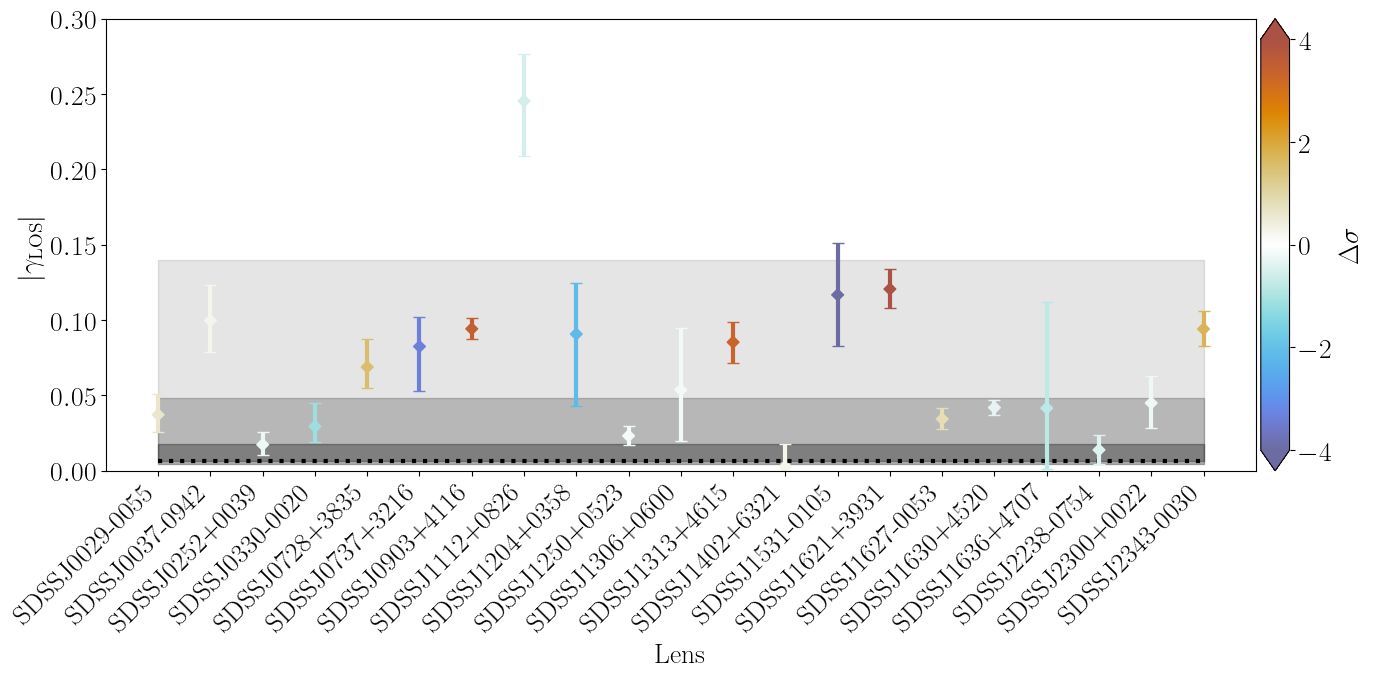

In [27]:
fig, ax = plt.subplots(1, 1, figsize=global_figsize)

ax.hlines(overall_summary_stats['mean'], xmin=0, xmax=len(filtered_bodi['Name'])-1, ls=':', color='k')

ax.fill_between(filtered_bodi['Name'], overall_summary_stats['mean'] - overall_summary_stats['lower_1sigma'],
                overall_summary_stats['mean'] + overall_summary_stats['upper_1sigma'], 
                color='k', alpha=0.3)

ax.fill_between(filtered_bodi['Name'], overall_summary_stats['mean'] - overall_summary_stats['lower_3sigma'],
                overall_summary_stats['mean'] + overall_summary_stats['upper_3sigma'], 
                color='k', alpha=0.2)

ax.fill_between(filtered_bodi['Name'], overall_summary_stats['mean'] - overall_summary_stats['lower_5sigma'],
                overall_summary_stats['mean'] + overall_summary_stats['upper_5sigma'], 
                color='k', alpha=0.1)

D = ax.scatter(filtered_bodi['Name'], filtered_bodi['gamma_los'], 
               c=filtered_tensions, marker='D', vmin=vmin_D, vmax=vmax_D, cmap=cmap_delta)

colorbar(D, r'$\Delta \sigma$', padding=0.05, extend='both', fontsize=bump_font)

# now get the cbar colours for the error bars
norm_D = colors.Normalize(vmin=vmin_D, vmax=vmax_D)
mapper_D = cm.ScalarMappable(norm=norm_D, cmap=cmap_delta)
colour_D = np.array([(mapper_D.to_rgba(d)) for d in filtered_tensions])

# loop over each point to get the right colour for each error bar
for x, y, lerr, uerr, color in zip(filtered_bodi['Name'], filtered_bodi['gamma_los'], 
                                   filtered_bodi['gamma_lower'], filtered_bodi['gamma_upper'], colour_D):
    ax.errorbar(x, y, yerr=[[lerr], [uerr]], color=color, capsize=4)

ax.set_ylim(0.0,0.3)

ax.tick_params(axis='both', which='major', labelsize=bump_font)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel(r'Lens', fontsize=bump_font)
ax.set_ylabel(r'$|\gamma_{\rm LOS}|$', fontsize=bump_font)

plt.tight_layout()

plt.show()

### Figure 8

This figure again relies on the version of ChainConsumer you should have installed to reproduce Figures 2-5 above.

In [28]:
params_bodi = [r'$\gamma_{\rm lens}$', r'$e_{1, \rm lens}$', r'$e_{2, \rm lens}$', r'$x_{\rm lens}$', r'$y_{\rm lens}$', r'$a_4$',
          r'$\gamma^{\rm od}_1$', r'$\gamma^{\rm od}_2$', r'$\gamma^{\rm LOS}_1$', r'$\gamma^{\rm LOS}_2$', r'$\omega^{\rm LOS}$', 
          r'$\beta$', r'$x_{\rm s}$', '$y_{\rm s}$', r'$R_{\rm Sersic, s}$', r'$n_{\rm Sersic, s}$', r'$e_1^{\rm s}$', r'$e_2^{\rm s}$',
          r'$R_{\rm Sersic, ll1}$', r'$e_1^{\rm ll1}$', r'$e_2^{\rm ll1}$', r'$x_{\rm ll}$', r'$y_{\rm ll}$', 
          r'$R_{\rm Sersic, l2}$',r'$e_1^{\rm ll2}$',r'$e_2^{\rm ll2}$',]

SDSSJ0737+3216
-0.8107837299433979 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8107837299433978
-0.8152416834947249 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8152416834947239


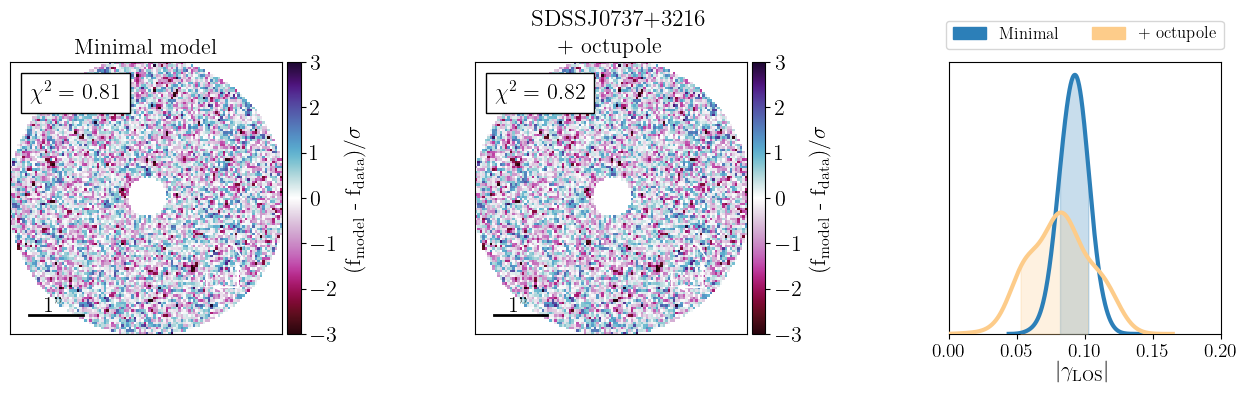

In [29]:
output = Output(path+'lens_modelling_results/')

lens_index = 7 # the relevant indices shown in the paper are 7, 24, 34; xlims are set by hand

# load the outputs
lens_name = lens_df.iloc[lens_index]['Name']
lens_filter = lens_df.iloc[lens_index]['Filter']
print(lens_name)

v_min       = lens_df['vmin'][lens_index] 
v_max       = lens_df['vmax'][lens_index] 
source_vmin = lens_df['source_vmin'][lens_index] 
source_vmax = lens_df['source_vmax'][lens_index] 
burnin = int(lens_df['burnin'][lens_index])
nsig = float(lens_df.iloc[lens_index]['nsig'])

# get the minimal model result
output.load_output(lens_name=lens_name, model_id='full', mask_path=mask_path)

kwargs_result_full = output.kwargs_result

# we get the ModelPlot object from which we extract the residuals
ModelPlot_full, vmax_full, chi2_full = output.get_model_plot(lens_name=lens_name, model_id='full',
                                                             mask_path=mask_path, kwargs_result=kwargs_result_full,
                                                             band_index=0, 
                                                             data_cmap = cmap_cubehelix)


# read in the chain
full_chain_dolphin = output.samples_mcmc

full_chain_unburned = pd.DataFrame.from_dict({par: val for par, val in zip(params, full_chain_dolphin.T)})

# remove burnin
full_chain = full_chain_unburned[burnin:]

full_g1_los_samples = full_chain[r'$\gamma^{\rm LOS}_1$']
full_g2_los_samples = full_chain[r'$\gamma^{\rm LOS}_2$']
full_gamma_los_samples = np.sqrt(full_g1_los_samples**2. + full_g2_los_samples**2.)
full_glos_df = pd.DataFrame(full_gamma_los_samples, columns=[r'|\gamma_{\rm LOS}|'])

# now the boxy/disky result
output.load_output(lens_name=lens_name, model_id='bodi', mask_path=mask_path)

kwargs_result_bodi = output.kwargs_result

ModelPlot_bodi, vmax_bodi, chi2_bodi = output.get_model_plot(lens_name=lens_name, model_id='bodi',
                                                             mask_path=mask_path, kwargs_result=kwargs_result_bodi,
                                                             band_index=0, 
                                                             data_cmap = cmap_cubehelix)

# read in the chain
bodi_chain_dolphin = output.samples_mcmc

bodi_chain_unburned = pd.DataFrame.from_dict({par: val for par, val in zip(params_bodi, bodi_chain_dolphin.T)})

# remove burnin
bodi_chain = bodi_chain_unburned[burnin:]

bodi_g1_los_samples = bodi_chain[r'$\gamma^{\rm LOS}_1$']
bodi_g2_los_samples = bodi_chain[r'$\gamma^{\rm LOS}_2$']
bodi_gamma_los_samples = np.sqrt(bodi_g1_los_samples**2. + bodi_g2_los_samples**2.)
bodi_glos_df = pd.DataFrame(bodi_gamma_los_samples, columns=[r'|\gamma_{\rm LOS}|'])

# set up plot
fig = plt.figure(figsize=(14,4))

ax_dict = fig.subplot_mosaic(
    [
        ["resid1", "resid2", "contour"],
    ],
)

# add elements
ModelPlot_full.normalized_residual_plot(band_index=0, ax=ax_dict['resid1'], 
                                        cmap=cmr.viola_r, text='', v_min=-3, v_max=3, font_size=global_fontsize)
ModelPlot_bodi.normalized_residual_plot(band_index=0, ax=ax_dict['resid2'], 
                                        cmap=cmr.viola_r, text='', v_min=-3, v_max=3, font_size=global_fontsize)


plot_dist(ax_dict['contour'], Chain(samples=full_glos_df, name=lens_name, shade=True, color='#2c7fb8', smooth=20, bins=10,
                                       shade_gradient = 0.4, linewidth=3.0), px=r"|\gamma_{\rm LOS}|",)
plot_dist(ax_dict['contour'], Chain(samples=bodi_glos_df, name=lens_name, shade=True, color='#fdcc8a', smooth=20, bins=10,
                                       shade_gradient = 0.4, linewidth=3.0), px=r"|\gamma_{\rm LOS}|")

# titles and axis labels
ax_dict['resid1'].set_title('Minimal model', fontsize=global_fontsize)
ax_dict['resid2'].set_title('+ octupole', fontsize=global_fontsize)

ax_dict['resid1'].add_artist(offsetbox.AnchoredText(r'$\chi^2 = $ {:.2f}'.format(chi2_full), 
                                                   loc='upper left', frameon=True, 
                                                   prop = {'fontsize':global_fontsize, 'color':'black'}))

ax_dict['resid2'].add_artist(offsetbox.AnchoredText(r'$\chi^2 = $ {:.2f}'.format(chi2_bodi), 
                                                   loc='upper left', frameon=True, 
                                                   prop = {'fontsize':global_fontsize, 'color':'black'}))

ax_dict['contour'].set_yticks([])
ax_dict['contour'].set_xlim(0.0, 0.2) # 0.3
ax_dict['contour'].set_ylim(bottom=0)
ax_dict['contour'].set_xlabel(r'$|\gamma_{\rm LOS}|$', fontsize=global_fontsize, labelpad=0)
ax_dict['contour'].axes.set_box_aspect(1)

yellow_patch = patches.Patch(color='#fdcc8a', label = '+ octupole')
blue_patch = patches.Patch(color='#2c7fb8', label = 'Minimal')

ax_dict['contour'].legend(handles=[blue_patch, yellow_patch], loc='center', bbox_to_anchor=(0.5, 1.1), 
                          ncol=2, fontsize=12).set_zorder(102)

fig.suptitle(lens_name)

fig.subplots_adjust(left=0.01, right=0.99, top=0.85, bottom=0.17, wspace=0.05)

plt.show()

### Figure 9

In [30]:
params_godf = [r'$\gamma_{\rm lens}$', r'$e_{1, \rm lens}$', r'$e_{2, \rm lens}$', r'$x_{\rm lens}$', r'$y_{\rm lens}$',
           r'$\gamma^{\rm LOS}_1$', r'$\gamma^{\rm LOS}_2$', r'$\omega^{\rm LOS}$', 
          r'$\beta$', r'$x_{\rm s}$', '$y_{\rm s}$', r'$R_{\rm Sersic, s}$', r'$n_{\rm Sersic, s}$', r'$e_1^{\rm s}$', r'$e_2^{\rm s}$',
          r'$R_{\rm Sersic, ll1}$', r'$e_1^{\rm ll1}$', r'$e_2^{\rm ll1}$', r'$x_{\rm ll}$', r'$y_{\rm ll}$', 
          r'$R_{\rm Sersic, l2}$',r'$e_1^{\rm ll2}$',r'$e_2^{\rm ll2}$',]

In [31]:
c = ChainConsumer()

lens_index = 39

lens_name = lens_df.iloc[lens_index]['Name']
burnin = int(lens_df['burnin'][lens_index])

In [32]:
output = Output(path+'lens_modelling_results/')
output.load_output(lens_name=lens_name, model_id='full', mask_path=mask_path)
full_chain_dolphin = output.samples_mcmc
full_chain_unburned = pd.DataFrame.from_dict({par: val for par, val in zip(params, full_chain_dolphin.T)})

In [33]:
output = Output(path+'lens_modelling_results/')
output.load_output(lens_name=lens_name, model_id='godf', mask_path=mask_path)
godf_chain_dolphin = output.samples_mcmc
godf_chain_unburned = pd.DataFrame.from_dict({par: val for par, val in zip(params_godf, godf_chain_dolphin.T)})

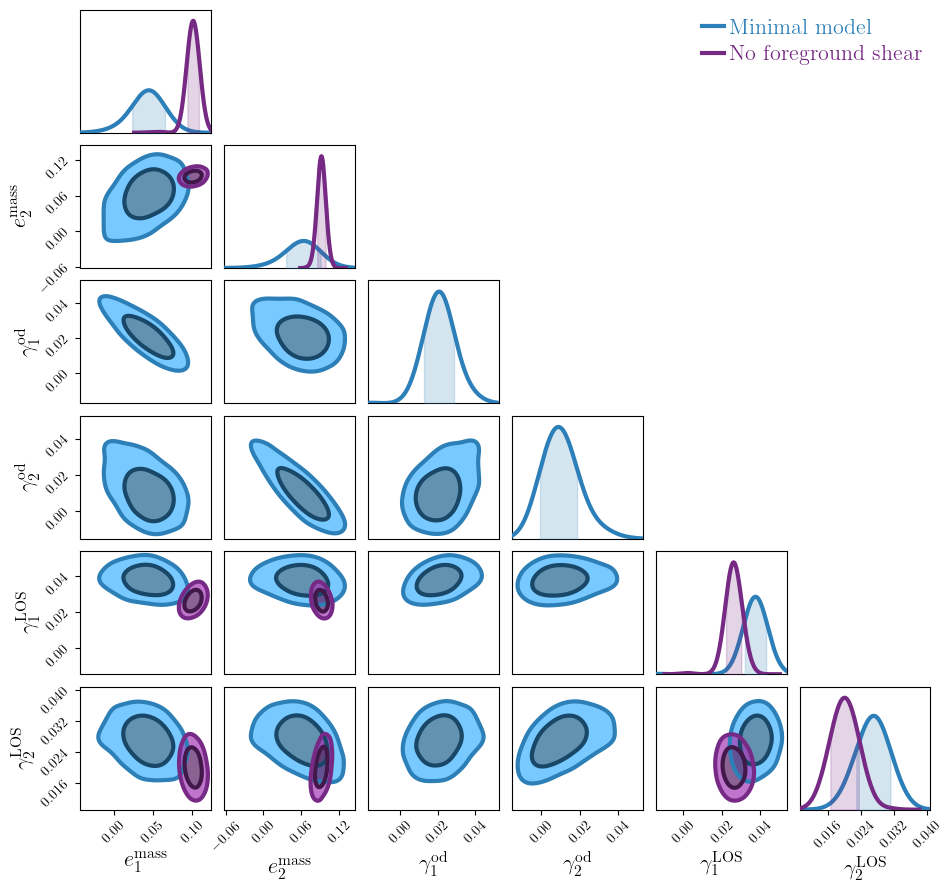

In [34]:
# rename the ellipticity parameters for aesthetic reasons
full_chain_unburned = full_chain_unburned.rename(columns={
      '$e_{1, \\rm lens}$': '$e_1^{\\rm mass}$',
      '$e_{2, \\rm lens}$': '$e_2^{\\rm mass}$',
  })

godf_chain_unburned = godf_chain_unburned.rename(columns={
      '$e_{1, \\rm lens}$': '$e_1^{\\rm mass}$',
      '$e_{2, \\rm lens}$': '$e_2^{\\rm mass}$',
  })

# remove burnin
full_chain = full_chain_unburned[burnin:]
godf_chain = godf_chain_unburned[burnin:]

params = ['$e_1^{\\rm mass}$', '$e_2^{\\rm mass}$',  
          '$\\gamma^{\\rm od}_1$', '$\\gamma^{\\rm od}_2$', 
          '$\\gamma^{\\rm LOS}_1$', '$\\gamma^{\\rm LOS}_2$', 
          ]

params1 = ['$e_1^{\\rm mass}$', '$e_2^{\\rm mass}$', 
           '$\\gamma^{\\rm LOS}_1$', '$\\gamma^{\\rm LOS}_2$', 
           ]

c.add_chain(Chain(samples=full_chain.loc[:, params],
                  name='Minimal model',
                  shade=True, color='#2c7fb8', smooth=20, bins=10,
                  shade_gradient = 1.0, linewidth=3.0))

c.add_chain(Chain(samples=godf_chain.loc[:, params1],
                  name='No foreground shear',
                  shade=True, color='#762a83', smooth=20, bins=10,
                  shade_gradient = 1.0, linewidth=3.0))

c.set_plot_config(PlotConfig(serif=True, usetex=True,
                             label_font_size=16, tick_font_size=10,
                             max_ticks = 4,
                             spacing=2.0))


fig = c.plotter.plot(figsize=(10,10))

plt.show()

### Figure 10

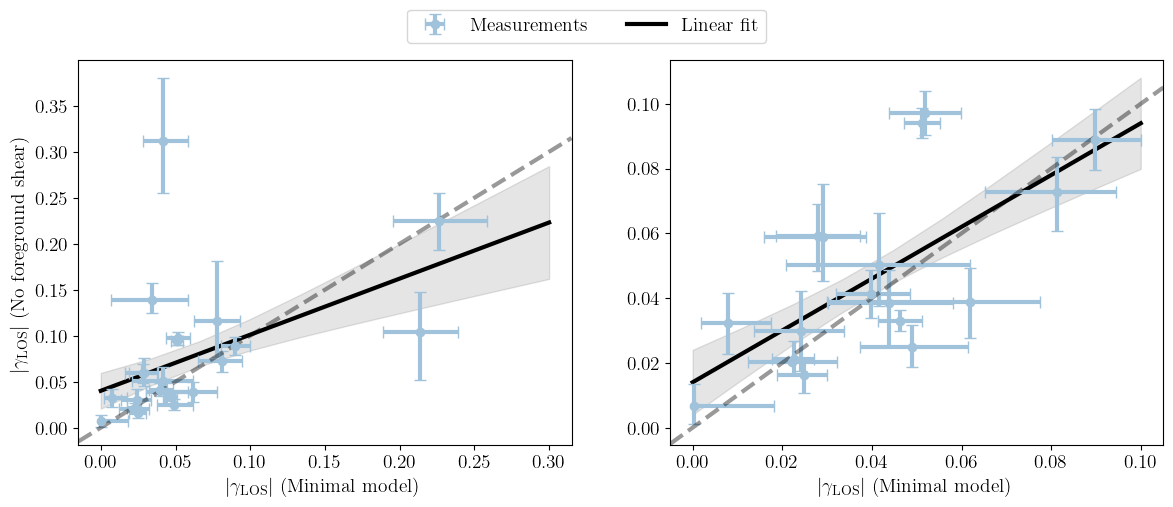

In [35]:
df = pd.merge(min_df, godf_df, left_index=True, right_index=True,
                       suffixes=('_min', '_godf'))

minimal = np.array(df['gamma_los_min'])
minimal_err = np.sqrt((df['gamma_lower_min']**2 + df['gamma_upper_min']**2) / 2)

godf = np.array(df['gamma_los_godf'])
godf_err = np.sqrt((df['gamma_lower_godf']**2 + df['gamma_upper_godf']**2) / 2)

x1 = minimal 
y1 = godf

shrunk_df= df.loc[df['gamma_los_godf'] < 0.1] # gets all rows where full < 0.1

shrunk_minimal = np.array(shrunk_df['gamma_los_min'])
shrunk_minimal_err = np.sqrt((shrunk_df['gamma_lower_min']**2 + shrunk_df['gamma_upper_min']**2) / 2)
shrunk_godf = np.array(shrunk_df['gamma_los_godf'])
shrunk_godf_err = np.sqrt((shrunk_df['gamma_lower_godf']**2 + shrunk_df['gamma_upper_godf']**2) / 2)

x2 = shrunk_minimal
y2 = shrunk_godf

n = 1  # degree of polynomial
t = np.linspace(0, 0.3, 10)  # space to interpolate over for plotting
t2 = np.linspace(0, 0.1, 10)  # space to interpolate over for plotting

TT = np.vstack([t**(n-i) for i in range(n+1)]).T # matrix with rows 1, t, t**2,...
TT2 = np.vstack([t2**(n-i) for i in range(n+1)]).T # matrix with rows 1, t, t**2,...

# fit minimal vs godf
p1, C_p1 = np.polyfit(x1, y1, n, cov=True) # C_p is estimated covariance matrix
yi1 = np.dot(TT, p1)  # matrix multiplication calculates the polynomial values
C_yi1 = np.dot(TT, np.dot(C_p1, TT.T)) # C_y = TT*C_p*TT.T
sig_yi1 = np.sqrt(np.diag(C_yi1))  # standard deviations are sqrt of diagonal

# shrunk fit
p2, C_p2 = np.polyfit(x2, y2, n, cov=True) # C_p is estimated covariance matrix
yi2 = np.dot(TT2, p2)  # matrix multiplication calculates the polynomial values
C_yi2 = np.dot(TT2, np.dot(C_p2, TT2.T)) # C_y = TT*C_p*TT.T
sig_yi2 = np.sqrt(np.diag(C_yi2))  # standard deviations are sqrt of diagonal

xlow = np.array(df['gamma_lower_min'])
xupp = np.array(df['gamma_upper_min'])
xerr = [xlow, xupp]

ylow = np.array(df['gamma_lower_godf'])
yupp = np.array(df['gamma_upper_godf'])
yerr = [ylow, yupp]

xlows = np.array(shrunk_df['gamma_lower_min'])
xupps = np.array(shrunk_df['gamma_upper_min'])
xerrs = [xlows, xupps]

ylows = np.array(shrunk_df['gamma_lower_godf'])
yupps = np.array(shrunk_df['gamma_upper_godf'])
yerrs = [ylows, yupps]

# plot
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].fill_between(t, yi1+sig_yi1, yi1-sig_yi1, color='k', alpha=0.1)
ax[0].plot(t, yi1, ls='-', color='k', label='Linear fit')
ax[0].errorbar(x1, y1, xerr=xerr, 
                       yerr=yerr, 
                       marker='o', ls=' ', capsize=4, label='Measurements')

ax[0].axline((0, 0), slope=1, color='k', alpha=0.4, ls='--')

ax[1].fill_between(t2, yi2+sig_yi2, yi2-sig_yi2, color='k', alpha=0.1)
ax[1].plot(t2, yi2, ls='-', color='k',)
ax[1].errorbar(x2, y2, xerr=xerrs, 
                       yerr=yerrs, 
                       marker='o', ls=' ', capsize=4)

ax[1].axline((0, 0), slope=1, color='k', alpha=0.4, ls='--')

ax[0].set_xlabel(r'$|\gamma_{\rm LOS}|$ (Minimal model)')
ax[1].set_xlabel(r'$|\gamma_{\rm LOS}|$ (Minimal model)')


fig.legend(frameon=True, ncol=2, loc='upper center', reverse=True)

ax[0].set_ylabel(r'$|\gamma_{\rm LOS}|$ (No foreground shear)')

plt.show()

### Table 1

Here we get all the information for, and print the LaTeX for Table 1.

In [36]:
# get n_max values from config files
n_max_list = []
for lens_name in min_df['Name']:
  config_file = path+'lens_modelling_results/full_settings/' + f'{lens_name}_config.yml'
  with open(config_file, 'r') as f:
      config = yaml.safe_load(f)
      n_max_list.append(config['source_light_option']['n_max'][0])

In [37]:
# add columns to dataframe
min_df['n_max'] = n_max_list
min_df['tension'] = zdzs_tensions
min_df['delta_sig'] = delta_tensions

In [38]:
# truncate to 3 decimal places
min_df['z_l'] = min_df['z_l'].apply(lambda x: f"{x:.3f}")
min_df['z_s'] = min_df['z_s'].apply(lambda x: f"{x:.3f}")

# truncate to 2 decimal places
min_df['tension'] = min_df['tension'].apply(lambda x: f"{x:.2f}")
min_df['delta_sig'] = min_df['delta_sig'].apply(lambda x: f"{x:.2f}")

In [39]:
# format the Name column to get minus signs in math mode
min_df['Name'] = min_df['Name'].str.replace('-', '$-$', regex=False)

In [40]:
# format the gamma_los column with +/- values
min_df['glos_formatted'] = min_df.apply(
  lambda row: f"${row['gamma_los']:.3f}^{{+{row['gamma_upper']:.3f}}}_{{-{row['gamma_lower']:.3f}}}$",
  axis=1)

In [41]:
# format the delta_sig column so minus signs are displayed in math mode and values align at the decimal point
min_df['delta_sig_formatted'] = min_df['delta_sig'].apply(
  lambda x: f"$-{abs(float(x)):.2f}$" if float(x) < 0 else f"~~{float(x):.2f}"
)

In [42]:
# remove the delta sigma for those two lenses whose gamma_los components didn't converge in the octupole model
min_df.loc[min_df['Name'].str.contains('0959|2303'), 'delta_sig_formatted'] = '~~n/a'

In [43]:
# rename columns with LaTeX-y names
min_df = min_df.rename(columns={
  'n_max': r'$n_{\rm max}$',
  'z_l': r'$z_{\rm lens}$',
  'z_s': r'$z_{\rm source}$',
  'glos_formatted': r'$|\gamma_{\rm LOS}|$',
  'tension': r'Tension [$\sigma$]',
  'delta_sig_formatted': r'$\Delta \sigma$'
})

In [44]:
# print the table
columns = ['Name', 'Filter', r'$n_{\rm max}$', 
           r'$z_{\rm lens}$', r'$z_{\rm source}$', 
           r'$|\gamma_{\rm LOS}|$', r'Tension [$\sigma$]', r'$\Delta \sigma$']

print(min_df[columns].to_latex(index=False, escape=False, column_format='llcccccc').replace('\\toprule', '\\hline \\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))

\begin{tabular}{llcccccc}
\hline \hline
Name & Filter & $n_{\rm max}$ & $z_{\rm lens}$ & $z_{\rm source}$ & $|\gamma_{\rm LOS}|$ & Tension [$\sigma$] & $\Delta \sigma$ \\
\hline
SDSSJ0029$-$0055 & F606W & 6 & 0.227 & 0.931 & $0.029^{+0.009}_{-0.013}$ & 1.30 & ~~0.61 \\
SDSSJ0037$-$0942 & F606W & 6 & 0.195 & 0.632 & $0.078^{+0.015}_{-0.016}$ & 3.88 & ~~0.26 \\
SDSSJ0252+0039 & F606W & 6 & 0.280 & 0.982 & $0.022^{+0.010}_{-0.010}$ & 0.85 & $-0.24$ \\
SDSSJ0330$-$0020 & F606W & 6 & 0.351 & 1.071 & $0.049^{+0.013}_{-0.012}$ & 1.99 & $-1.14$ \\
SDSSJ0728+3835 & F606W & 16 & 0.206 & 0.688 & $0.042^{+0.017}_{-0.013}$ & 2.16 & ~~1.53 \\
SDSSJ0737+3216 & F555W & 6 & 0.322 & 0.581 & $0.090^{+0.010}_{-0.010}$ & 4.86 & $-3.36$ \\
SDSSJ0903+4116 & F606W & 6 & 0.430 & 1.065 & $0.052^{+0.008}_{-0.008}$ & 1.98 & ~~3.46 \\
SDSSJ0959+0410 & F555W & 16 & 0.126 & 0.535 & $0.040^{+0.009}_{-0.008}$ & 3.34 & ~~n/a \\
SDSSJ1112+0826 & F606W & 6 & 0.273 & 0.629 & $0.226^{+0.032}_{-0.030}$ & 6.65 & $-0.57$ \\
S

### Table 2

Currently unable to exactly reproduce this programatically; hline placement is an issue. This is close enough.

In [45]:
from dolphin.processor.config import ModelConfig

# Load a config file to get the priors
config_file = path + 'lens_modelling_results/bodi_settings/SDSSJ0008-0004_config.yml'
config = ModelConfig(file=config_file)

# Get the parameter bounds
lens_params = config.get_lens_model_params()  # [init, sigma, fixed, lower, upper]
lens_light_params = config.get_lens_light_model_params()
source_params = config.get_source_light_model_params()

# Extract bounds (index 3=lower, 4=upper)
lens_lower, lens_upper = lens_params[3], lens_params[4]
lens_light_lower, lens_light_upper = lens_light_params[3], lens_light_params[4]
source_lower, source_upper = source_params[3], source_params[4]

# Helper function to format priors
def format_prior(lower, upper, param_name='', log_scale=False):
  """Format a prior as a LaTeX string."""
  if log_scale:
      return rf"$\log_{{10}} [{lower:.2f}'', {upper:.2f}'']$"
  # Check if it's a position parameter (has arcsec units)
  if 'center' in param_name or param_name in ['x', 'y']:
      return rf"$[{lower:.2f}'', {upper:.2f}'']$"
  else:
      return rf"$[{lower:.2f}, {upper:.2f}]$"

# Map parameters
epl_idx = 0
los_idx = 1 if len(lens_lower) > 1 else None
has_octupole = 'a4_a' in lens_lower[epl_idx] if epl_idx < len(lens_lower) else False
centroid_bound = config.deflector_centroid_bound

# Build table data
table_data = []

# Lens mass - 5 rows
table_data.append(['', r'$\gamma^{\rm EPL}$', format_prior(lens_lower[epl_idx]['gamma'], lens_upper[epl_idx]['gamma'])])
table_data.append(['', r'$e_1$', format_prior(lens_lower[epl_idx]['e1'], lens_upper[epl_idx]['e1'])])
table_data.append(['Lens mass', r'$e_2$', format_prior(lens_lower[epl_idx]['e2'], lens_upper[epl_idx]['e2'])])
table_data.append(['', r'$x$', format_prior(-centroid_bound, centroid_bound, param_name='x')])
table_data.append(['', r'$y$', format_prior(-centroid_bound, centroid_bound, param_name='y')])

# Lens light - 5 rows
table_data.append(['', r'$R_{\rm{eff}}$', format_prior(lens_light_lower[0]['R_sersic'], lens_light_upper[0]['R_sersic'])])
table_data.append(['', r'$e_1$', format_prior(lens_light_lower[0]['e1'], lens_light_upper[0]['e1'])])
table_data.append(['Lens light', r'$e_2$', format_prior(lens_light_lower[0]['e2'], lens_light_upper[0]['e2'])])
table_data.append(['', r'$x$', format_prior(-centroid_bound, centroid_bound, param_name='x')])
table_data.append(['', r'$y$', format_prior(-centroid_bound, centroid_bound, param_name='y')])

# Source light - 7 rows
table_data.append(['', r'$\beta$', format_prior(source_lower[0]['beta'], source_upper[0]['beta'], log_scale=True)])
table_data.append(['', r'$R_{\rm{eff}}$', format_prior(source_lower[1]['R_sersic'], source_upper[1]['R_sersic'], param_name='center')])
table_data.append(['', r'$n_{\rm{S}}$', format_prior(source_lower[1]['n_sersic'], source_upper[1]['n_sersic'])])
table_data.append(['Source light', r'$e_1$', format_prior(source_lower[1]['e1'], source_upper[1]['e1'])])
table_data.append(['', r'$e_2$', format_prior(source_lower[1]['e2'], source_upper[1]['e2'])])
table_data.append(['', r'$x$', r"$[-0.2'', 0.2'']$"])
table_data.append(['', r'$y$', r"$[-0.2'', 0.2'']$"])

# Shear - 5 rows
if los_idx is not None:
  table_data.append(['', r'$\gamma_1^{\rm od}$', format_prior(lens_lower[los_idx]['gamma1_od'], lens_upper[los_idx]['gamma1_od'])])
  table_data.append(['', r'$\gamma_2^{\rm od}$', format_prior(lens_lower[los_idx]['gamma2_od'], lens_upper[los_idx]['gamma2_od'])])
  table_data.append(['Shear', r'$\gamma_1^{\rm LOS}$', format_prior(lens_lower[los_idx]['gamma1_los'], lens_upper[los_idx]['gamma1_los'])])
  table_data.append(['', r'$\gamma_2^{\rm LOS}$', format_prior(lens_lower[los_idx]['gamma2_los'], lens_upper[los_idx]['gamma2_los'])])
  table_data.append(['', r'$\omega^{\rm LOS}$', format_prior(lens_lower[los_idx]['omega_los'], lens_upper[los_idx]['omega_los'])])

# Octupole - 4 rows
if has_octupole:
  table_data.append(['', r'$a_4$', format_prior(lens_lower[epl_idx]['a4_a'], lens_upper[epl_idx]['a4_a'])])
  table_data.append(['Octupole', r'$\phi_4$', r'$[-\pi, \pi]$'])
  table_data.append(['', r'$x$', format_prior(-centroid_bound, centroid_bound, param_name='x')])
  table_data.append(['', r'$y$', format_prior(-centroid_bound, centroid_bound, param_name='y')])

# Create dataframe
df = pd.DataFrame(table_data, columns=['Component', 'Parameter', 'Prior'])

# Generate LaTeX
latex_output = df.to_latex(index=False, escape=False, column_format='llll')

# Replace booktabs - keep only header and footer hlines
latex_output = latex_output.replace('\\toprule', '\\hline\n\\hline')
latex_output = latex_output.replace('\\midrule', '\\hline')
latex_output = latex_output.replace('\\bottomrule', '\\hline')

print(latex_output)

\begin{tabular}{llll}
\hline
\hline
Component & Parameter & Prior \\
\hline
 & $\gamma^{\rm EPL}$ & $[1.30, 2.80]$ \\
 & $e_1$ & $[-0.50, 0.50]$ \\
Lens mass & $e_2$ & $[-0.50, 0.50]$ \\
 & $x$ & $[-0.50'', 0.50'']$ \\
 & $y$ & $[-0.50'', 0.50'']$ \\
 & $R_{\rm{eff}}$ & $[0.10, 5.00]$ \\
 & $e_1$ & $[-0.50, 0.50]$ \\
Lens light & $e_2$ & $[-0.50, 0.50]$ \\
 & $x$ & $[-0.50'', 0.50'']$ \\
 & $y$ & $[-0.50'', 0.50'']$ \\
 & $\beta$ & $\log_{10} [0.02'', 0.20'']$ \\
 & $R_{\rm{eff}}$ & $[0.04'', 0.50'']$ \\
 & $n_{\rm{S}}$ & $[0.50, 8.00]$ \\
Source light & $e_1$ & $[-0.50, 0.50]$ \\
 & $e_2$ & $[-0.50, 0.50]$ \\
 & $x$ & $[-0.2'', 0.2'']$ \\
 & $y$ & $[-0.2'', 0.2'']$ \\
 & $\gamma_1^{\rm od}$ & $[-0.20, 0.20]$ \\
 & $\gamma_2^{\rm od}$ & $[-0.20, 0.20]$ \\
Shear & $\gamma_1^{\rm LOS}$ & $[-0.50, 0.50]$ \\
 & $\gamma_2^{\rm LOS}$ & $[-0.50, 0.50]$ \\
 & $\omega^{\rm LOS}$ & $[-0.20, 0.20]$ \\
 & $a_4$ & $[-0.10, 0.10]$ \\
Octupole & $\phi_4$ & $[-\pi, \pi]$ \\
 & $x$ & $[-0.50'', 0.50'']